# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Значение метрики RMSE должно быть меньше 2500

# Описание данных:

**Признаки**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Цеоевой признак**

- `Price` — цена (евро)

## Подготовка данных

### Импорт используемых библиотек

In [134]:
import re
import pandas as pd
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import timeit
import lightgbm as lgb

from pycaret.regression import RegressionExperiment

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from time import time

#отключение предупреждений
import warnings
warnings.filterwarnings(action='ignore')

In [135]:
np.random.seed(42)

In [136]:
%matplotlib inline

### Чтение файла

In [137]:
try:
    df = pd.read_csv('autos.csv', sep=',')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', sep=',')

In [138]:
ydata_profiling.ProfileReport(df, explorative=True).to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Датасет содержит:
- 16 столбцов
- **354369** строк
- 3.2% пропусков
- 4 дубликата
___
- Столбцы `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` имеют пропуски
- В столбце `Price` самая популярная цена - 0 (~10000 автомобилей).
- Год, фигурирующий в `DateCrawled` - 2016.
- Года, фигурирующий в `DateCreated` - 2014-2016.
- `RegistrationYear` имеет аномальные значения - 1000, 9999 и другие выбросы
- `Power` имеет аномальные значения - 0, 20000 л.с. и другие выбросы
- `RegistrationMonth` имеет аномальное значение - 0 месяц
- `NumberOfPictures` имеет только одно значение - 1

## Предобработка данных

Приведем к нижниму и змеинному регистрам названия столбцов

In [139]:
df.rename(columns=lambda x: re.sub('(?!^)([A-Z]+)', r'_\1',x).lower(), inplace=True)

In [140]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Удалим лишние признаки: столбцы `date_crawled`, `date_created`, `last_seen`, `number_of_pictures`, `postal_code` т.к. в них информации о самом автомобиле нет. Также удалим `registration_month` - не столь значимый параметр, который влияет на цену.

In [141]:
df = df.drop(
    ['date_crawled',
     'date_created',
     'last_seen',
     'number_of_pictures',
     'postal_code',
     'registration_month'],
    axis=1)

### Столбец `registration_year`

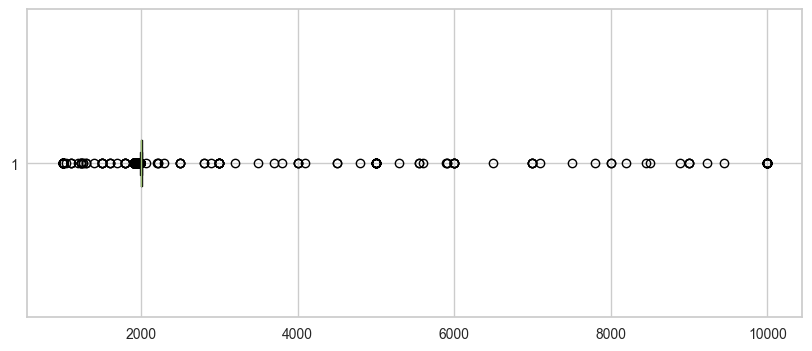

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [142]:
plt.figure(figsize=(10, 4))
plt.boxplot(df['registration_year'], vert=False)
plt.grid(True)
plt.show()

df['registration_year'].describe()

Узнаем долю аномалий в столбце `registration_year`

Будет исходить из того, что за нижний порог даты регистрации автомобиля будет взят 1980, верхний - 2016.

In [143]:
anomaly_reg_year = (
    df.query('registration_year < 1980 | registration_year > 2016')
)

print('Доля объявлений автомобилей с годом регистрации до 1980 и после 2022 годов - ',
      round(anomaly_reg_year.shape[0] / df.shape[0] * 100, 2),'%')

Доля объявлений автомобилей с годом регистрации до 1980 и после 2022 годов -  5.07 %


Удалим из датасета аномалии

In [144]:
df = df.query('1980 <= registration_year <= 2016')

### Столбец `power`

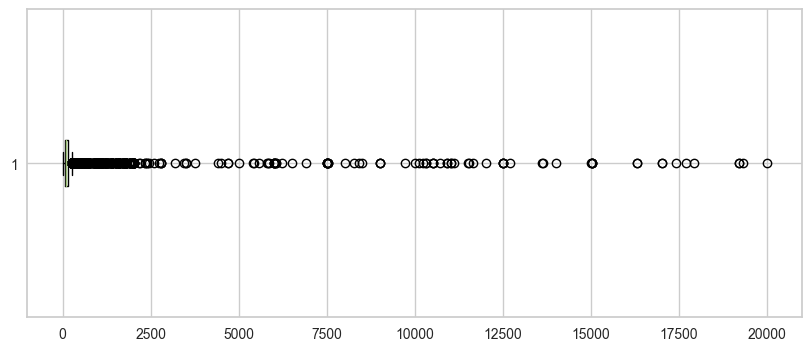

count    336387.000000
mean        111.366973
std         185.510237
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [145]:
plt.figure(figsize=(10, 4))
plt.boxplot(df['power'], vert=False)
plt.grid(True)
plt.show()

df['power'].describe()

Узнаем долю аномально высоких значений в столбце `power`

В различных источниках значение в 3000 л.с. является самым большим у автомобилей, будем придерживаться этого порога.

In [146]:
anomaly_power = (
    df.query('power > 3000')
)

print('Доля объявлений автомобилей с аномально высоким значением л. с. - ',
      round(anomaly_power.shape[0] / df.shape[0] * 100, 2),'%')

Доля объявлений автомобилей с аномально высоким значением л. с. -  0.02 %


Удалим из датасета эти аномалии

In [147]:
df = df.query('power <= 3000')

Посмотрим на редкие значения

In [148]:
df['power'].value_counts().tail()

525     1
1625    1
1151    1
685     1
1241    1
Name: power, dtype: int64

Заменим редкие значения на медиану для удобства деления на выборки

In [149]:
power_counts = df['power'].value_counts()

rare_power = power_counts[power_counts < 10].index

# Замените значения на "other"
df.loc[df['power'].isin(rare_power), 'power'] = df['power'].median()

In [150]:
df['power'].value_counts().tail()

335    10
269    10
10     10
236    10
2      10
Name: power, dtype: int64

Узнаем долю нулевых значений

In [151]:
anomaly_power = (
    df.query('power == 0')
)

print('Доля объявлений автомобилей с нулевым значением л. с. - ',
      round(anomaly_power.shape[0] / df.shape[0] * 100, 2),'%')

Доля объявлений автомобилей с нулевым значением л. с. -  10.52 %


Корректным будет удалить такие наблюдения - у нас остаётся достаточно много наблюдений, чтобы мы могли без существенных потреь удалить их.

In [152]:
df = df.query('power > 0')

### Столбец `price`

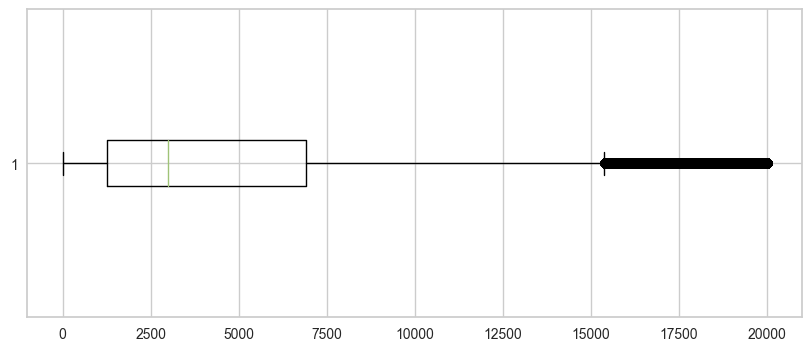

count    300936.000000
mean       4727.078415
std        4600.126389
min           0.000000
25%        1250.000000
50%        3000.000000
75%        6900.000000
max       20000.000000
Name: price, dtype: float64

In [153]:
plt.figure(figsize=(10, 4))
plt.boxplot(df['price'], vert=False)
plt.grid(True)
plt.show()

df['price'].describe()

В цене есть аномально низкие значения, рассмотрим их

In [154]:
df.query('price < 10')['price'].value_counts(normalize=True) * 100

0    90.468705
1     9.188340
5     0.128608
2     0.100029
3     0.057159
9     0.057159
Name: price, dtype: float64

В экстремально низких ценах (до 10) 0 и 1 составляют долю 99%.
___
Поскольку цена является целевым признаком, а значения 0 и 1 свидетельствуют о высокой доли вероятности ошибки в указанных объявлениях, поэтому в целях обучения удалим данные объекты.

In [155]:
df = df.query('price >= 10')

### Столбец `vehicle_type`

Посмотрим на данные в столбце `vehicle_type`

In [116]:
print('Доля пропусков: {0:.2%}'.format(df['vehicle_type'].isna().sum() / df.shape[0]))

df['vehicle_type'].value_counts(normalize=True) * 100

Доля пропусков: 3.71%


sedan          29.041877
small          24.662330
wagon          20.889052
bus             9.225807
convertible     6.510672
coupe           5.000300
suv             3.823094
other           0.846868
Name: vehicle_type, dtype: float64

Заполним пропуски самым часто встречающимся типом автомобильного кузова для каждой модели и марки

In [117]:
# Группировка данных по марке и модели, подсчет количества для каждого типа транспортного средства
type_by_brand_model = df.groupby(['brand', 'model', 'vehicle_type'])['vehicle_type'].count().unstack()

# Выбор самого частого типа транспортного средства для каждой марки и модели
most_common_types = type_by_brand_model.idxmax(axis=1)

# Заполнение пропусков в столбце VehicleType наиболее частыми типами для соответствующей марки и модели
def fill_vehicle_type(row):
    if pd.isnull(row['vehicle_type']):
        return most_common_types.get((row['brand'], row['model']), 'unknown')
    return row['vehicle_type']

In [118]:
df['vehicle_type'] = df.apply(fill_vehicle_type, axis=1)

In [119]:
df['vehicle_type'].isna().sum()

0

Пропуски отсутствуют

### Столбец `gearbox`

`gearbox` содержит в себе категориальные данные, посмотрим на них.

In [120]:
print('Доля пропусков: {0:.2%}'.format(df['gearbox'].isna().sum() / df.shape[0]))
df['gearbox'].value_counts(normalize=True) * 100

Доля пропусков: 1.79%


manual    79.782875
auto      20.217125
Name: gearbox, dtype: float64

Доли примерно 4 к 1, поэтому логично присвоить пропускам в столбце значение `manual`. И сразу же проверим изменившиееся соотношение

In [121]:
df['gearbox'] = df['gearbox'].fillna('manual')
df['gearbox'].value_counts(normalize=True) * 100

manual    80.144452
auto      19.855548
Name: gearbox, dtype: float64

Соотношение практически не изменилось

### Столбец `model`

Посмотрим на данные в столбце `model`

In [122]:
print('Доля пропусков: {0:.2%}'.format(df['model'].isna().sum() / df.shape[0]))
df['model'].value_counts(normalize=True) * 100

Доля пропусков: 3.64%


golf                  8.708762
other                 6.853745
3er                   6.120071
polo                  3.767583
corsa                 3.567394
                        ...   
i3                    0.001765
samara                0.001765
rangerover            0.000706
serie_2               0.000706
range_rover_evoque    0.000706
Name: model, Length: 248, dtype: float64

Заполнить пропуски каким-то понятным значением навряд ли получится. Заполним пропуски категорией other

In [123]:
df['model'] = df['model'].fillna('other')

Для упрощения обучения присвоим редким моделям ту же категорию - other.

In [124]:
model_counts = df['model'].value_counts()

rare_models = model_counts[model_counts < 10].index

# Замените значения на "other"
df.loc[df['model'].isin(rare_models), 'model'] = 'other'

In [125]:
rare_models

Index(['elefantino', 'kalina', 'i3', 'samara', 'range_rover_evoque',
       'rangerover', 'serie_2'],
      dtype='object')

### Столбец `fuel_type`

Посмотрим на данные в столбце `fuel_type`

In [126]:
print('Доля пропусков: {0:.2%}'.format(df['fuel_type'].isna().sum() / df.shape[0]))
df['fuel_type'].value_counts(normalize=True) * 100

Доля пропусков: 5.22%


petrol      66.545824
gasoline    31.479654
lpg          1.673732
cng          0.172650
hybrid       0.072147
other        0.029074
electric     0.026920
Name: fuel_type, dtype: float64

`petrol` и `gasoline` по своей природе являются бензином, следовательно их можно объединить под одну категорию.
`lpg` и `cng` - газовое топливо, их также можно объединить в одну категорию.

In [127]:
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')
df['fuel_type'] = df['fuel_type'].replace('cng', 'lpg')

Т.к. автомобили с бензиновым топливом занимают почти все предложение, целесообразно заполнить пустоты именно этим типом топлива.

In [128]:
df['fuel_type'] = df['fuel_type'].fillna('petrol')

In [129]:
df['fuel_type'].value_counts(normalize=True) * 100

petrol      98.128517
lpg          1.750029
hybrid       0.068382
other        0.027557
electric     0.025516
Name: fuel_type, dtype: float64

### Столбец `repaired`

Посмотрим на данные в столбце `repaired`

In [130]:
print('Доля пропусков: {0:.2%}'.format(df['repaired'].isna().sum() / df.shape[0]))
df['repaired'].value_counts(normalize=True) * 100

Доля пропусков: 14.42%


no     88.632695
yes    11.367305
Name: repaired, dtype: float64

Менять пропуски на какое-либо значение из существующих (yes/no) было бы некорректно. Введем новую категорию - `unknown`

In [131]:
df['repaired'] = df['repaired'].fillna('unknown')

### Удаление дубликатов

Изначально было всего 4 дубликата, посмотрим, изменилось ли количество после работы с исходными данными

In [132]:
df.duplicated().sum()

42371

Появилось много дубликатов. Столбцы, связанные с датами (дата скачивания анкеты из базы, дата создания анкеты) были удалены, следовательно можно сделать вывод, что одна и та же машина могла публиковаться несколько раз. Удалим дубликаты

In [133]:
df = df.drop_duplicates()
df.duplicated().sum()

0

### Вывод:

Посмотрим на инофрмацию о датасете после предобработки

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251567 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              251567 non-null  int64 
 1   vehicle_type       251567 non-null  object
 2   registration_year  251567 non-null  int64 
 3   gearbox            251567 non-null  object
 4   power              251567 non-null  int64 
 5   model              251567 non-null  object
 6   kilometer          251567 non-null  int64 
 7   fuel_type          251567 non-null  object
 8   brand              251567 non-null  object
 9   repaired           251567 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.1+ MB


Пропуски отсутствуют
___
В ходе предобработки были предприняты следующие действия с данными:
- Перевели в нижний и змеинный регистры названия признаков (столбцов)
- Удалили лишние признаки (`date_crawled`, `date_created`, `last_seen`, `number_of_pictures`, `postal_code`,`registration_month`), в которых отсутствует информация об автомобилях
- Удалили строки с аномальными значениями в столбце `registration_year`
- Удалили строки с аномальными значениями в столбце `power` и заменили редкие медианой
- Удалили строки с аномальными значениями в столбце `price`
- Заполнили пропуски самым часто встречающимся типом автомобильного кузова для каждой модели и марки в столбце `vehicle_type`
- Заполнили пропуски значением **manual** в столбце `gearbox`
- Присвоим редким моделям и пропускам тзначение **other** в столбце `model`
- В столбце `fuel_type` объединили значения **petrol** и **gasoline**, также - **lpg** и **cng**
- Ввели новую категорию **unknown** вместо пустот в столбце `repaired`
- После всех преобразований образовалось 42371 дубликатов. Все они были удалены.

## Обучение моделей

### Разделение данных на обучающую и тестовую выборки

Введем переменные с признаками и целевым признаком

In [41]:
features = df.drop(['price'], axis=1)
target = df['price']

Разделим набор данных на обучающую (`features_train`), валидационную (`features_valid`) и тестовую выборки (`features_test`)

In [42]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.2)

print('Обучающая выборка:', features_train.shape[0])
print('Тестовая выборка:', features_test.shape[0])

Обучающая выборка: 201253
Тестовая выборка: 50314


### Преобразование признаков

Выделим категориальные признаки

In [43]:
categorical_features = features_train.select_dtypes(include=['object']).columns.tolist()

categorical_features

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

Поменяем тип категориальных признаков с `object` на `category`

In [44]:
features_train[categorical_features] = features_train[categorical_features].astype('category')
features_test[categorical_features] = features_test[categorical_features].astype('category')

features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201253 entries, 211579 to 159624
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_type       201253 non-null  category
 1   registration_year  201253 non-null  int64   
 2   gearbox            201253 non-null  category
 3   power              201253 non-null  int64   
 4   model              201253 non-null  category
 5   kilometer          201253 non-null  int64   
 6   fuel_type          201253 non-null  category
 7   brand              201253 non-null  category
 8   repaired           201253 non-null  category
dtypes: category(6), int64(3)
memory usage: 7.5 MB


Преобразуем категориальные признаки в численные с помощью техники OrdinalEncoder

In [45]:
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

Выделим числовые признаки

In [46]:
numeric_features = features_train.select_dtypes(include=['int64']).columns.tolist()

numeric_features

['registration_year', 'power', 'kilometer']

Стандартизируем численные данные с помощью StandardScaler

In [47]:
numeric_transformer = StandardScaler()

Используем ColumnTransformer для применения различных преобразований к разным столбцам данных.

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [91]:
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['registration_year', 'power', 'kilometer']),
                                ('cat',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'repaired'])])

### Модели

Воспользуемся функцией RegressionExperiment библиотеки **PyCaret**, чтобы узнать наиболее подходящие модели для обучения

In [50]:
exp = RegressionExperiment()
type(exp)

pycaret.regression.oop.RegressionExperiment

In [51]:
exp.setup(df, target='price', session_id=123)

,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(251567, 10)"
4,Transformed data shape,"(251567, 24)"
5,Transformed train set shape,"(176096, 24)"
6,Transformed test set shape,"(75471, 24)"
7,Ordinal features,1
8,Numeric features,3
9,Categorical features,6


In [52]:
best = exp.compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1026.6820,2602740.8272,1613.1901,0.8802,0.4876,0.4976,7.7950
xgboost,Extreme Gradient Boosting,1036.6942,2647915.5639,1627.1360,0.8781,0.4899,0.4980,3.6340
rf,Random Forest Regressor,1044.7829,2752600.7829,1658.9389,0.8733,0.4852,0.4983,13.6940
lightgbm,Light Gradient Boosting Machine,1081.2351,2824821.1197,1680.6104,0.8699,0.4964,0.5271,0.8040
et,Extra Trees Regressor,1076.8293,2930221.6652,1711.6883,0.8651,0.5012,0.5077,20.3480
gbr,Gradient Boosting Regressor,1217.6557,3466462.7688,1861.6599,0.8404,0.5482,0.5911,4.5800
dt,Decision Tree Regressor,1209.7166,4031665.4420,2007.6638,0.8144,0.5682,0.5382,0.4740
knn,K Neighbors Regressor,1274.6355,4282922.1402,2069.4549,0.8028,0.5513,0.6235,2.4210
br,Bayesian Ridge,1958.4132,7367955.4354,2714.3094,0.6608,0.8688,1.2123,0.4010
ridge,Ridge Regression,1958.4287,7367967.7203,2714.3117,0.6608,0.8687,1.2123,0.3380


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Для дальнейшего обучения возьмем топ-4 модели:
- `CatBoost Regressor`
- `Extreme Gradient Boosting`
- `Random Forest Regressor`
- `Light Gradient Boosting Machine`

Создадим датасет, в который будут собираться результаты обучения моделей

In [65]:
best_models = pd.DataFrame(columns=['model', 'RMSE', 'Время обучения', 'Время предсказания'])

#### CatBoostRegressor

In [66]:
pipeline_catboost = Pipeline([
    ('preprocessor', preprocessor),
    ("catboost", CatBoostRegressor(loss_function='RMSE', verbose=25))
])

param_grid = {
    'catboost__iterations': [100, 200, 301],
    'catboost__learning_rate': [0.01, 0.1, 0.2],
    'catboost__depth': [6, 8, 10]
}

grid_catboost = GridSearchCV(estimator=pipeline_catboost,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             cv=5,
                             n_jobs=-1)

start_learn = time()
grid_catboost.fit(features_train, target_train)
end_learn = time()

learn_time = end_learn - start_learn #время поиска лучшей модели

rmse_catboost = np.sqrt(abs(grid_catboost.best_score_))

print('Время поиска лучшей модели:', round(learn_time, 2), 'сек.')
print("Лучшие параметры:", grid_catboost.best_params_)
print("Лучший RMSE:", rmse_catboost)

0:	learn: 3992.5051060	total: 24.7ms	remaining: 7.42s
25:	learn: 1760.2080582	total: 624ms	remaining: 6.6s
50:	learn: 1667.5923259	total: 1.19s	remaining: 5.82s
75:	learn: 1616.3167027	total: 1.74s	remaining: 5.16s
100:	learn: 1577.7393648	total: 2.32s	remaining: 4.59s
125:	learn: 1548.6386340	total: 2.9s	remaining: 4.03s
150:	learn: 1524.2525833	total: 3.47s	remaining: 3.44s
175:	learn: 1504.4417769	total: 4.03s	remaining: 2.86s
200:	learn: 1484.9121340	total: 4.63s	remaining: 2.31s
225:	learn: 1470.5586882	total: 5.21s	remaining: 1.73s
250:	learn: 1458.6016029	total: 5.76s	remaining: 1.15s
275:	learn: 1446.1364323	total: 6.33s	remaining: 574ms
300:	learn: 1435.2537222	total: 6.9s	remaining: 0us
Время поиска лучшей модели: 318.91 сек.
Лучшие параметры: {'catboost__depth': 10, 'catboost__iterations': 301, 'catboost__learning_rate': 0.2}
Лучший RMSE: 1592.3770156497621


In [67]:
best_model_catboost = grid_catboost.best_estimator_

start_fit = time()
best_model_catboost.fit(features_train, target_train)
end_fit = time()

fit_time = end_fit - start_fit
print("Время обучения лучшей модели:", round(fit_time, 2), "сек")

start_pred = time()
predictions = best_model_catboost.predict(features_train)
end_pred = time()

pred_time = end_pred - start_pred
print('Время предсказания лучшей модели:', round(pred_time, 2), 'сек.')

0:	learn: 3992.5051060	total: 24.6ms	remaining: 7.37s
25:	learn: 1760.2080582	total: 594ms	remaining: 6.28s
50:	learn: 1667.5923259	total: 1.16s	remaining: 5.69s
75:	learn: 1616.3167027	total: 1.76s	remaining: 5.21s
100:	learn: 1577.7393648	total: 2.32s	remaining: 4.59s
125:	learn: 1548.6386340	total: 2.88s	remaining: 4.01s
150:	learn: 1524.2525833	total: 3.46s	remaining: 3.43s
175:	learn: 1504.4417769	total: 4.03s	remaining: 2.86s
200:	learn: 1484.9121340	total: 4.61s	remaining: 2.29s
225:	learn: 1470.5586882	total: 5.18s	remaining: 1.72s
250:	learn: 1458.6016029	total: 5.77s	remaining: 1.15s
275:	learn: 1446.1364323	total: 6.33s	remaining: 573ms
300:	learn: 1435.2537222	total: 6.89s	remaining: 0us
Время обучения лучшей модели: 7.65 сек
Время предсказания лучшей модели: 0.66 сек.


In [68]:
best_models.loc[0] = ['CatBoostRegressor', rmse_catboost, fit_time, pred_time]

#### XGBRegressor

In [69]:
pipeline_xgb = Pipeline(
    [
        (('preprocessor', preprocessor)),
        ("xgb", XGBRegressor())
    ]
)

param_grid = {
    'xgb__n_estimators': [50, 100],
    'xgb__max_depth': [5, 10],
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(estimator=pipeline_xgb,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        cv=5,
                        n_jobs=-1)

start_fit = time()
grid_xgb.fit(features_train, target_train)
end_fit = time()

rmse_xgb = np.sqrt(abs(grid_xgb.best_score_))

print("Лучшие параметры:", grid_xgb.best_params_)
print("Лучший RMSE:", rmse_xgb)
print('Время поиска лучшей модели:', round(end_fit - start_fit, 2), 'сек.')

Лучшие параметры: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
Лучший RMSE: 1581.068421228847
Время поиска лучшей модели: 184.92 сек.


In [70]:
best_model_xgb = grid_xgb.best_estimator_

start_fit = time()
best_model_xgb.fit(features_train, target_train)
end_fit = time()

fit_time = end_fit - start_fit
print("Время обучения лучшей модели:", round(fit_time, 2), "сек")

start_pred = time()
predictions = best_model_xgb.predict(features_train)
end_pred = time()

pred_time = end_pred - start_pred
print('Время предсказания лучшей модели:', round(pred_time, 2), 'сек.')

Время обучения лучшей модели: 7.25 сек
Время предсказания лучшей модели: 0.31 сек.


In [71]:
best_models.loc[1] = ['XGBRegressor', rmse_xgb, fit_time, pred_time]

#### RandomForestRegressor

In [81]:
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor())
])

param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [5, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(estimator=pipeline_rf,
                       param_grid=param_grid,
                       scoring='neg_mean_squared_error',
                       cv=5,
                       n_jobs=-1)

start_fit = time()
grid_rf.fit(features_train, target_train)
end_fit = time()

rmse_rf = np.sqrt(abs(grid_rf.best_score_))

print("Лучшие параметры:", grid_rf.best_params_)
print("Лучший RMSE:", rmse_rf)
print('Время поиска лучшей модели:', round(end_fit - start_fit, 2), 'сек.')

Лучшие параметры: {'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Лучший RMSE: 1881.1291987682644
Время поиска лучшей модели: 319.47 сек.


In [82]:
best_model_rf = grid_rf.best_estimator_

start_fit = time()
best_model_rf.fit(features_train, target_train)
end_fit = time()

fit_time = end_fit - start_fit
print("Время обучения лучшей модели:", round(fit_time, 2), "сек")

start_pred = time()
predictions = best_model_rf.predict(features_train)
end_pred = time()

pred_time = end_pred - start_pred
print('Время предсказания лучшей модели:', round(pred_time, 2), 'сек.')

Время обучения лучшей модели: 23.01 сек
Время предсказания лучшей модели: 1.95 сек.


In [83]:
best_models.loc[2] = ['RandomForestRegressor', rmse_rf, fit_time, pred_time]

#### LGBMRegressor

In [84]:
pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ("lgbm", LGBMRegressor(force_row_wise=True))
])

param_grid = {
    'lgbm__n_estimators': [50, 100, 200],
    'lgbm__max_depth': [5, 10, 15],
    'lgbm__learning_rate': [0.01, 0.1, 0.2]
}

grid_lgbm = GridSearchCV(estimator=pipeline_lgbm,
                         param_grid=param_grid,
                         scoring='neg_mean_squared_error',
                         cv=5,
                         n_jobs=-1)

start_fit = time()
grid_lgbm.fit(features_train, target_train)
end_fit = time()

rmse_lgbm = np.sqrt(abs(grid_lgbm.best_score_))

print("Лучшие параметры:", grid_lgbm.best_params_)
print("Лучший RMSE:", rmse_lgbm)
print('Время поиска лучшей модели:', round(end_fit - start_fit, 2), 'сек.')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 201253, number of used features: 9
[LightGBM] [Info] Start training from score 4952.039816
Лучшие параметры: {'lgbm__learning_rate': 0.2, 'lgbm__max_depth': 15, 'lgbm__n_estimators': 200}
Лучший RMSE: 1616.1967226975062
Время поиска лучшей модели: 74.52 сек.


In [85]:
best_model_lgbm = grid_lgbm.best_estimator_

start_fit = time()
best_model_lgbm.fit(features_train, target_train)
end_fit = time()

fit_time = end_fit - start_fit
print("Время обучения лучшей модели:", round(fit_time, 2), "сек")

start_pred = time()
predictions = best_model_lgbm.predict(features_train)
end_pred = time()

pred_time = end_pred - start_pred
print('Время предсказания лучшей модели:', round(pred_time, 2), 'сек.')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 201253, number of used features: 9
[LightGBM] [Info] Start training from score 4952.039816
Время обучения лучшей модели: 0.71 сек
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Время предсказания лучшей модели: 0.57 сек.


In [86]:
best_models.loc[3] = ['LGBMRegressor', rmse_lgbm, fit_time, pred_time]

#### DummyRegressor

In [87]:
dummy_model = DummyRegressor(strategy='mean') 

dummy_model.fit(features_train, target_train)

dummy_predictions = dummy_model.predict(features_test)

rmse_dummy = mean_squared_error(target_test, dummy_predictions, squared=False)

print(f"RMSE константной модели: {rmse_dummy}")

RMSE константной модели: 4648.648862493507


Все модели прошли тест на адекватность - метрика RMSE константной модели равна **4648**.

Посмотрим на результаты моделей

In [89]:
best_models.sort_values('RMSE')

,model,RMSE,Время обучения,Время предсказания
1,XGBRegressor,1581.068421,7.249033,0.313668
0,CatBoostRegressor,1592.377016,7.649867,0.664223
3,LGBMRegressor,1616.196723,0.706322,0.569993
2,RandomForestRegressor,1881.129199,23.007074,1.946989


`XGBRegressor` показала наилучшую метрику RMSE, поэтому ее будем анализировать на тестовой выборке

## Анализ модели

In [90]:
rmse_test = mean_squared_error(target_test, best_model_xgb.predict(features_test), squared=False)

print("RMSE на тестовых данных с использованием лучших параметров:", rmse_test)

RMSE на тестовых данных с использованием лучших параметров: 1573.7256674764717


Результат тестирования лучшей модели - **1573**

## Вывод

Датасет содержал:

- 16 столбцов
- 354369 строк
- 3.2% пропусков
- 4 дубликата
- Несколько признаков имели аномальные значения, которые нужно было обработать
___
В ходе предобработки были предприняты следующие действия с данными:

- Перевели в нижний и змеинный регистры названия признаков (столбцов)
- Удалили лишние признаки (date_crawled, date_created, last_seen, number_of_pictures, postal_code,registration_month), в которых отсутствует информация об автомобилях
- Удалили строки с аномальными значениями в столбце registration_year
- Удалили строки с аномальными значениями в столбце power и заменили редкие медианой
- Удалили строки с аномальными значениями в столбце price
- Заполнили пропуски самым часто встречающимся типом автомобильного кузова для каждой модели и марки в столбце vehicle_type
- Заполнили пропуски значением manual в столбце gearbox
- Присвоим редким моделям и пропускам тзначение other в столбце model
- В столбце fuel_type объединили значения petrol и gasoline, также - lpg и cng
- Ввели новую категорию unknown вместо пустот в столбце repaired
- После всех преобразований образовалось 42371 дубликатов. Все они были удалены.
___
Разделили данные на обучающую и тестовую выборки в соотношении 4:1
___
Преобразовали категориальные признаки, масштабировали числовые признаки
___
Функцией compare_models() оценили несколько регрессионных моделей, которые подходят под нашу задачу. По оценке метрики RMSE были выбраны 4 модели для дальнейшего обучения:
- `CatBoost Regressor`
- `Extreme Gradient Boosting`
- `Random Forest Regressor`
- `Light Gradient Boosting Machine`
___
Наилучшую метрику RMSE показала модель `XGBRegressor` (Extreme Gradient Boosting) - **1581**. Гиперпараметры лучшей модели:
- learning_rate: 0.1
- max_depth: 10
- n_estimators: 100
- subsample: 0.8

Значение RMSE лучшей модели на тестовой выборке - **1573**
___
**На основании исследования по предоставленным данным, заказчику стоит порекомендовать модель экстремального градиентного бустинга XGBRegressor**